In [ ]:
!pip uninstall imgaug --yes
!pip install imgaug

Found existing installation: imgaug 0.4.0
Uninstalling imgaug-0.4.0:
  Successfully uninstalled imgaug-0.4.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached imgaug-0.4.0-py2.py3-none-any.whl (948 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.


In [ ]:
!git clone https://github.com/axelcarlier/projsemisup.git
path = "./projsemisup/"

fatal: destination path 'projsemisup' already exists and is not an empty directory.


In [ ]:
from imgaug import augmenters as iaa
import imgaug as ia
rand_aug = iaa.RandAugment(n=2, m=9)
import tensorflow as tf


def augment(images):
    # Input to `augment()` is a TensorFlow tensor which
    # is not supported by `imgaug`. This is why we first
    # convert it to its `numpy` variant.
    images = tf.cast(images, tf.uint8)
    return rand_aug(images=images.numpy())

aug = lambda x: (tf.py_function(augment, [x], [tf.float32])[0])/255


In [ ]:
#x_lab, y_lab, x_unlab, x_test, y_test = load_semisup_data(path, classes=CLASSES)
#x_test = x_test/255

In [ ]:
import numpy as np
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

x_lab = x_train[:2500]
x_unlab = x_train[2500:10000]

y_lab = y_train[:2500]

170508288/170498071 [==============================] - 4s 0us/step
(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [ ]:
print(x_lab.shape, y_lab.shape)
print(x_unlab.shape)
print(x_test.shape, y_test.shape)

(2500, 32, 32, 3) (2500, 1)
(7500, 32, 32, 3)
(10000, 32, 32, 3) (10000, 1)


In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import Input, Model

def build_model(Nbclasses=95, image_size=64):
  input = Input(shape=(image_size, image_size, 3))

  x = Conv2D(64,(3,3),activation='relu', padding='same')(input)
  x = MaxPooling2D(pool_size=(2,2))(x)
  x = Conv2D(128,(3,3),activation='relu', padding='same')(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
  x = Conv2D(256,(3,3),activation='relu', padding='same')(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
  x = Flatten()(x)
  x = Dense(512, activation='relu')(x)
  output = Dense(Nbclasses, activation='linear')(x)

  model = Model(inputs=input, outputs=output)

  return model

model = build_model(Nbclasses = 10, image_size = 32)
model.summary()
# model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4), metrics=["sparse_categorical_accuracy"])
# model.fit(x_lab, y_lab, validation_data=(x_test,y_test), epochs=100, batch_size=10)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         295168

In [ ]:
import numpy as np
# Données et modèle du problème des 2 clusters
history = []
# Nombre d'epochs de l'apprentissage
epochs = 50
# Nombre de données non-labellisées par batch
bs_unlab = 16*3
# Nombre de données labellisées par batch
bs_lab = 16
# Taille du batch
batch_size = bs_lab + bs_unlab ## = 32 comme dans UDA
# Valeur initiale du paramètre de contrôle de l'importance de la régularisation non-supervisée
lambda_t = 1

# Nombre de batches par epochs
steps_per_epochs = int(np.floor(x_lab.shape[0]/bs_lab))
# Instanciation d'un optimiseur et d'une fonction de coût.
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)

# Préparation des métriques pour le suivi de la performance du modèle.
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

# Indices de l'ensemble non labellisé
indices_lab = np.arange(x_lab.shape[0]) 
# Indices de l'ensemble non labellisé
indices_unlab = np.arange(x_unlab.shape[0]) 

In [ ]:
supervised_loss = tf.keras.losses.SparseCategoricalCrossentropy()

def consistency_loss(p_logits, q_logits):
    p = tf.nn.softmax(p_logits)
    log_p = tf.nn.log_softmax(p_logits)
    log_q = tf.nn.log_softmax(q_logits)

    kl = tf.reduce_sum(p * (log_p - log_q), -1)
    kl = tf.cast(kl, tf.float32)
    return kl

def decay_weights(cost, model, weight_decay_rate=5e-4):
  """Calculates the loss for l2 weight decay and adds it to `cost`."""
  costs = []
  for var in model.trainable_variables:
    costs.append(tf.nn.l2_loss(var))
  cost += tf.math.multiply(weight_decay_rate, tf.math.add_n(costs))
  return cost

In [ ]:
NUM_CLASSES = 10
def get_eta_threshold(global_step, num_train_steps, start, end=1) :
  step_ratio = tf.cast(global_step, tf.float32) /  tf.cast(num_train_steps, tf.float32) 
  scale = 5
  coeff = 1 - tf.exp((-step_ratio) * scale)
  #coeff = step_ratio
  #coeff = 1
  return coeff * (end - start) + start

def anneal_sup_loss(sup_logits, sup_labels, sup_loss, global_step):
  eta_start = 1. / NUM_CLASSES
  eta = get_eta_threshold(epoch, epochs, eta_start)

  one_hot_labels = tf.one_hot(sup_labels, depth=NUM_CLASSES, dtype=tf.float32)
  sup_probs = tf.nn.softmax(sup_logits, axis=-1)

  correct_label_probs = tf.reduce_sum(one_hot_labels * sup_probs, axis=-1)

  larger_than_threshold = tf.greater(correct_label_probs, eta)

  loss_mask = 1 - tf.cast(larger_than_threshold, tf.float32)
  loss_mask = tf.stop_gradient(loss_mask)

  sup_loss = sup_loss * loss_mask

  avg_sup_loss = (tf.reduce_sum(sup_loss) /
                  tf.maximum(tf.reduce_sum(loss_mask), 1))
  
  return sup_loss, avg_sup_loss

def get_ent(logits):
    log_prob = tf.nn.log_softmax(logits, axis=-1)
    prob = tf.exp(log_prob)
    ent = tf.reduce_sum(-prob * log_prob, axis=-1)
    tf.reduce_mean(ent)
    return ent


In [ ]:
beta = 0.8
tau = 0.4
history = []

x_test_norm = x_test/255

for epoch in range(epochs):

  print(f"tsa threshold : {get_eta_threshold(epoch, epochs, 1/10, end=1)}")
    
  mask_sum = 0

  for b in range(steps_per_epochs):


    # Les données d'un batch sont constituées de l'intégralité de nos données labellisées...
    x_batch_lab = x_lab[indices_lab[b*bs_lab:(b+1)*bs_lab]]
    y_batch_lab = y_lab[indices_lab[b*bs_lab:(b+1)*bs_lab]]
    # y_batch_lab = np.expand_dims(y_batch_lab,1)
    # ... ainsi que de données non-labellisées !
    x_batch_unlab = x_unlab[indices_unlab[b*bs_unlab:(b+1)*bs_unlab]]
    # unlabeled augmented data
    x_batch_aug = aug(x_batch_unlab)

    # Normalization
    x_batch_lab = x_batch_lab/255
    x_batch_unlab = x_batch_unlab/255

    # Les opérations effectuées par le modèle dans ce bloc sont suivies et permettront
    # la différentiation automatique.
    with tf.GradientTape() as tape:

      # SUPERVISED PART
      sup_logits = model(x_batch_lab, training=True)
      sup_probs = tf.nn.softmax(sup_logits, axis=-1)
      # Cross entropy with annealing higher probs regarding tsa threshold 
      sup_loss = supervised_loss(y_batch_lab, sup_probs)
      sup_loss = tf.cast(sup_loss, tf.float32)
      sup_loss = tf.reduce_mean(sup_loss)

      _, sup_loss = anneal_sup_loss(sup_logits, y_batch_lab, sup_loss, epoch)


      # # UNSUPERVISED PART
      ori_logits = model(x_batch_unlab, training=True)
      aug_logits = model(x_batch_aug, training=True)
      ori_logits_tgt = ori_logits / tau

      # # Consistency loss
      unsup_loss = consistency_loss(p_logits=tf.stop_gradient(ori_logits_tgt), q_logits=aug_logits)
      

      # # get most confident predictions
      ori_prob = tf.nn.softmax(ori_logits, axis=-1)
      largest_prob = tf.reduce_max(ori_prob, axis=-1)
      loss_mask = tf.cast(tf.greater(largest_prob, beta), tf.float32)
      loss_mask = tf.stop_gradient(loss_mask)
      mask_sum += np.sum(loss_mask.numpy())
      unsup_loss = unsup_loss * loss_mask
      unsup_loss = tf.reduce_mean(unsup_loss)

      # min_ent = tf.reduce_mean(get_ent(ori_logits))

      total_loss = sup_loss + unsup_loss# + 0.5 * min_ent

      # # L2 regularisation
      total_loss = decay_weights(total_loss, model)

      # Calcul des gradients par différentiation automatique
      grads = tape.gradient(total_loss, model.trainable_weights)
      # Réalisation d'une itération de la descente de gradient (mise à jour des paramètres du réseau)
      optimizer.apply_gradients(zip(grads, model.trainable_weights))

      # Mise à jour de la métrique
      train_acc_metric.update_state(y_batch_lab, sup_probs)

  # Calcul de la précision à la fin de l'epoch
  train_acc = train_acc_metric.result()
  # Calcul de la précision sur l'ensemble de validation à la fin de l'epoch
  val_logits = model(x_test_norm, training=False)
  val_pred = tf.nn.softmax(val_logits, axis=-1)

  val_acc_metric.update_state(y_test, val_pred)
  val_acc = val_acc_metric.result()
  history.append((train_acc,val_acc))
  print("Epoch %4d : Loss : %.4f (Mask sum : %d), Acc : %.4f, Val Acc : %.4f" % (epoch, float(total_loss), mask_sum, float(train_acc), float(val_acc)))

  # Remise à zéro des métriques pour la prochaine epoch
  train_acc_metric.reset_states()
  val_acc_metric.reset_states()


tsa threshold : 0.10000000149011612
Epoch    0 : Loss : 1.8686 (Mask sum : 0), Acc : 0.2336, Val Acc : 0.3506
tsa threshold : 0.18564626574516296
Epoch    1 : Loss : 1.5580 (Mask sum : 86), Acc : 0.3802, Val Acc : 0.4062
tsa threshold : 0.26314231753349304
Epoch    2 : Loss : 1.3799 (Mask sum : 237), Acc : 0.4443, Val Acc : 0.4315
tsa threshold : 0.3332636058330536
Epoch    3 : Loss : 1.1848 (Mask sum : 423), Acc : 0.4840, Val Acc : 0.4540
tsa threshold : 0.39671191573143005
Epoch    4 : Loss : 1.0643 (Mask sum : 687), Acc : 0.5256, Val Acc : 0.4761
tsa threshold : 0.454122394323349
Epoch    5 : Loss : 0.9459 (Mask sum : 969), Acc : 0.5693, Val Acc : 0.4961
tsa threshold : 0.506069540977478
Epoch    6 : Loss : 0.8283 (Mask sum : 1289), Acc : 0.6066, Val Acc : 0.5127
tsa threshold : 0.5530732274055481
Epoch    7 : Loss : 1.1323 (Mask sum : 1594), Acc : 0.6518, Val Acc : 0.5119
tsa threshold : 0.595603883266449
Epoch    8 : Loss : 0.7915 (Mask sum : 1943), Acc : 0.6871, Val Acc : 0.5280


In [ ]:
train_accuracy = []
val_accuracy = []
for i in range(0, len(history)) :
  train_accuracy.append(history[i][0])
  val_accuracy.append(history[i][1])

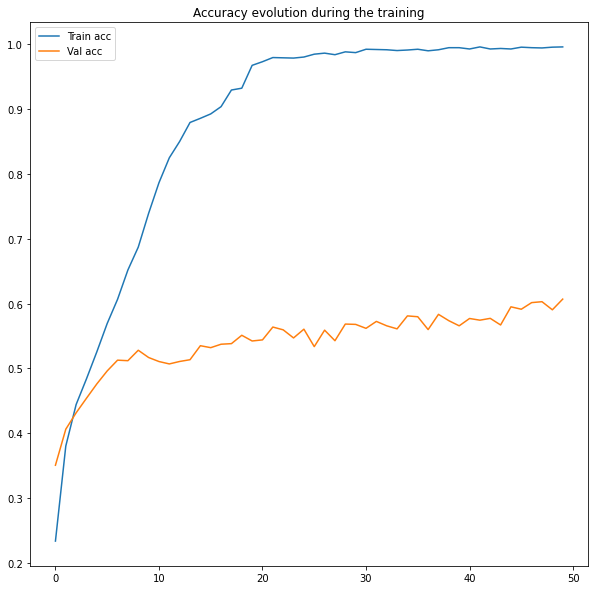

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(0, 50), train_accuracy, label='Train acc')
plt.plot(np.arange(0, 50), val_accuracy, label='Val acc')
plt.legend()
plt.title('Accuracy evolution during the training')
plt.show()